STEP 1: DATA COLLECTION AND CLEANING

In [26]:
# Step 1: Import libraries

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Step 2: Dataset Path

DATASET_SRC = '/kaggle/input/time-series-air-quality-data-of-india-2010-2023'

In [27]:
# List all files inside the dataset folder
files = os.listdir(DATASET_SRC)
print("Total files available:", len(files))
print("First 10 files:", files[:10])  # show first 10 file names


Total files available: 454
First 10 files: ['DL023.csv', 'WB005.csv', 'MH018.csv', 'UP017.csv', 'BR008.csv', 'BR003.csv', 'MP016.csv', 'KA035.csv', 'CH001.csv', 'PY001.csv']


In [28]:
# Load one sample file
sample_file = os.path.join(DATASET_SRC, "DL023.csv")
df = pd.read_csv(sample_file)

# Check shape and first few rows
print("Shape:", df.shape)
df.head()

Shape: (45230, 22)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),...,Toluene (),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm)
0,2018-02-01 10:00:00,2018-02-01 11:00:00,322.00,487.00,4.53,26.33,18.72,24.92,11.06,0.58,...,NaN,NaN,36.60,1.86,298.60,601.00,994.00,0.0,22.16,NaN
1,2018-02-01 11:00:00,2018-02-01 12:00:00,245.92,427.42,5.96,26.08,32.14,37.77,20.26,0.94,...,NaN,NaN,32.75,1.98,296.42,602.00,994.00,0.0,24.08,NaN
2,2018-02-01 12:00:00,2018-02-01 13:00:00,176.67,368.83,2.70,15.93,18.62,38.67,12.48,0.73,...,NaN,NaN,34.17,1.95,297.00,602.92,992.92,0.0,25.52,NaN
3,2018-02-01 13:00:00,2018-02-01 14:00:00,149.00,333.75,1.33,11.37,23.08,24.69,4.28,0.61,...,NaN,NaN,32.92,2.58,310.58,603.00,991.83,0.0,26.36,NaN
4,2018-02-01 14:00:00,2018-02-01 15:00:00,113.08,273.25,1.22,15.52,33.15,7.96,0.53,0.52,...,NaN,NaN,31.58,2.80,318.08,603.00,990.92,0.0,26.77,NaN


In [29]:
df_states = pd.read_csv(f'{DATASET_SRC}/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [30]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

In [31]:
def combine_state_df(state_name):
    '''
    Combine all state files into a single dataframe and attaching the city information.

    Parameters
    ----------
        state_name (str): The name of the state

    Return
    ------
        df (DataFrame): The combined dataframe from all files of a specific state
    '''
    
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'{DATASET_SRC}/{state_code}*.csv')
    print(f'Combining a total of {len(state_files)} files...\n')

    combined_df = []
    
    for state_file in state_files:
        file_name = state_file.split(f'{DATASET_SRC}/')[1][0:-4]
        file_df = pd.read_csv(state_file)
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        combined_df.append(file_df)
        
    return pd.concat(combined_df)

In [32]:
df = combine_state_df('Delhi')
df.info()

Combining a total of 40 files...

<class 'pandas.core.frame.DataFrame'>
Index: 2796171 entries, 0 to 113961
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (ug/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene ()           float64
 13  Temp (degree C)      float64
 14  RH (%)               float64
 15  WS (m/s)             float64
 16  WD (degree)          float64
 17  SR (W/mt2)           float64
 18  BP (mmHg)            float64
 19  VWS (m/s)            float64
 20  AT (degree C)        float64
 21  RF (mm)              float64
 22  city                 string 
 23  CO (

In [33]:
# combining all states 
all_states_df = []

for state in unique_states:
    try:
        state_df = combine_state_df(state)   # use your existing function
        all_states_df.append(state_df)
        print(f"{state} combined successfully with shape {state_df.shape}")
    except Exception as e:
        print(f"Error combining {state}: {e}")

# Concatenate into one master DataFrame
master_df = pd.concat(all_states_df, ignore_index=True)
print("Master dataset shape:", master_df.shape)

Combining a total of 10 files...

Andhra Pradesh combined successfully with shape (272217, 29)
Combining a total of 1 files...

Arunachal Pradesh combined successfully with shape (17655, 26)
Combining a total of 9 files...

Assam combined successfully with shape (75171, 26)
Combining a total of 35 files...

Bihar combined successfully with shape (741917, 32)
Combining a total of 14 files...

Chhattisgarh combined successfully with shape (62952, 28)
Combining a total of 3 files...

Chandigarh combined successfully with shape (56647, 26)
Combining a total of 40 files...

Delhi combined successfully with shape (2796171, 60)
Combining a total of 17 files...

Gujarat combined successfully with shape (442880, 31)
Combining a total of 1 files...

Himachal Pradesh combined successfully with shape (9247, 24)
Combining a total of 30 files...

Haryana combined successfully with shape (1228631, 51)
Combining a total of 2 files...

Jharkhand combined successfully with shape (52638, 21)
Combining a 

In [34]:
# remove the unnecessary columns

useful_cols = ['From Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 
               'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)', 'city']

master_df = master_df[useful_cols]

In [35]:
# print all columns
print(master_df.columns.tolist())


['From Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)', 'city']


In [36]:
# for time series analysis , we have to use " from date" column as the main timestamp

# for that rename the "from date" to "date"

master_df = master_df.rename(columns = {"From Date": "date"})

In [37]:
# print all columns
print(master_df.columns.tolist())

['date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)', 'city']


In [38]:
master_df['date'] = pd.to_datetime(master_df['date'], errors='coerce')

In [39]:
# print column type

print(master_df['date'].dtype)

datetime64[ns]


In [40]:
# Feature engineering to extract time -based features 'from date' column
master_df['year']= master_df['date'].dt.year
master_df['year']

0           2017
1           2017
2           2017
3           2017
4           2017
            ... 
14295658    2023
14295659    2023
14295660    2023
14295661    2023
14295662    2023
Name: year, Length: 14295663, dtype: int32

In [41]:
master_df['month'] = master_df['date'].dt.month

In [42]:
master_df['day_of_week'] = master_df['date'].dt.dayofweek
master_df['day_of_week']

0           4
1           4
2           4
3           4
4           4
           ..
14295658    4
14295659    4
14295660    4
14295661    4
14295662    4
Name: day_of_week, Length: 14295663, dtype: int32

In [43]:
# handling missing values
# remove pm2.5 missing rows
master_df =  master_df.dropna(subset=['PM2.5 (ug/m3)'])

In [44]:
# fill other missing values 
master_df[['PM10 (ug/m3)', 'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)']] = (
    master_df[['PM10 (ug/m3)', 'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)']].fillna(method='ffill')
)

/tmp/ipykernel_36/1320347037.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_df[['PM10 (ug/m3)', 'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)']].fillna(method='ffill')


In [45]:
master_df.head()

,date,PM2.5 (ug/m3),PM10 (ug/m3),NO2 (ug/m3),SO2 (ug/m3),Ozone (ug/m3),city,year,month,day_of_week
0,2017-11-24 16:00:00,60.50,98.00,30.80,11.85,126.40,Amaravati,2017,11,4
1,2017-11-24 17:00:00,65.50,111.25,24.20,13.17,117.12,Amaravati,2017,11,4
2,2017-11-24 18:00:00,80.00,132.00,25.18,12.08,98.98,Amaravati,2017,11,4
3,2017-11-24 19:00:00,81.50,133.25,16.25,10.47,112.20,Amaravati,2017,11,4
4,2017-11-24 20:00:00,75.25,116.00,17.48,9.12,106.35,Amaravati,2017,11,4


In [46]:
# creating lag feature because it is useful in time series : as it helps in predicting today's PM2.5 using previous day
master_df['PM2.5_prev_day'] = master_df.groupby('city')['PM2.5 (ug/m3)'].shift(1)
master_df['PM2.5_prev_day'] 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0             NaN
1           60.50
2           65.50
3           80.00
4           81.50
            ...  
14295658    33.68
14295659    33.96
14295660    30.73
14295661    26.22
14295662    25.40
Name: PM2.5_prev_day, Length: 10357694, dtype: float64

In [47]:
#save the cleaned dataset

master_df.to_csv('/kaggle/working/air_quality_clean.csv', index=False)

In [52]:
from IPython.display import FileLink
FileLink('/kaggle/working/air_quality_clean.csv')

/kaggle/working/air_quality_clean.csv

STEP 2 : EXPLORATORY DATA ANALYSIS


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


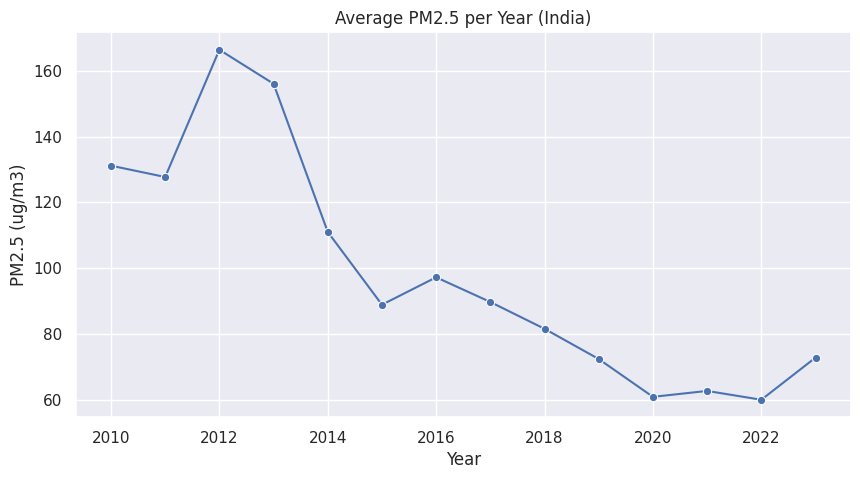

In [48]:
# 1. temporal analysis(Yearly & Monthly Trends)
# average PM2.5 per year

avg_pm25_year = master_df.groupby('year')['PM2.5 (ug/m3)'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=avg_pm25_year, x='year', y='PM2.5 (ug/m3)', marker='o')
plt.title('Average PM2.5 per Year (India)')
plt.ylabel('PM2.5 (ug/m3)')
plt.xlabel('Year')
plt.show()

Number of cities reporting data each year:
    year  city
0   2010     1
1   2011     1
2   2012     2
3   2013     6
4   2014     4
5   2015    19
6   2016    26
7   2017    49
8   2018    74
9   2019   113
10  2020   135
11  2021   166
12  2022   205
13  2023   232


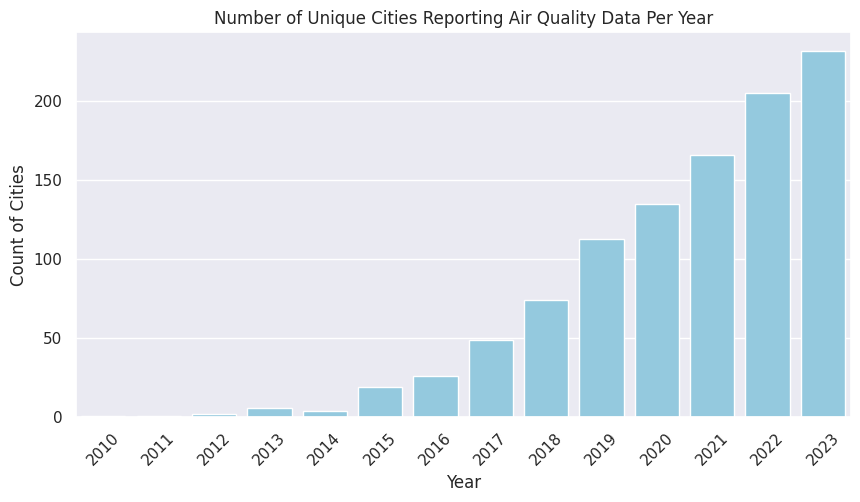

In [49]:
# INVESTIGATE DATA AVAILABILITY OVER THE YEARS 

# Count the number of unique cities reporting data for each year
cities_per_year = master_df.groupby('year')['city'].nunique().reset_index()

print("Number of cities reporting data each year:")
print(cities_per_year)

# Plot the number of cities over time
plt.figure(figsize=(10, 5))
sns.barplot(data=cities_per_year, x='year', y='city', color='skyblue')
plt.title('Number of Unique Cities Reporting Air Quality Data Per Year')
plt.ylabel('Count of Cities')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.show()

Found 49 cities that were reporting data back in 2017.
Created a new dataframe with a consistent set of cities 


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


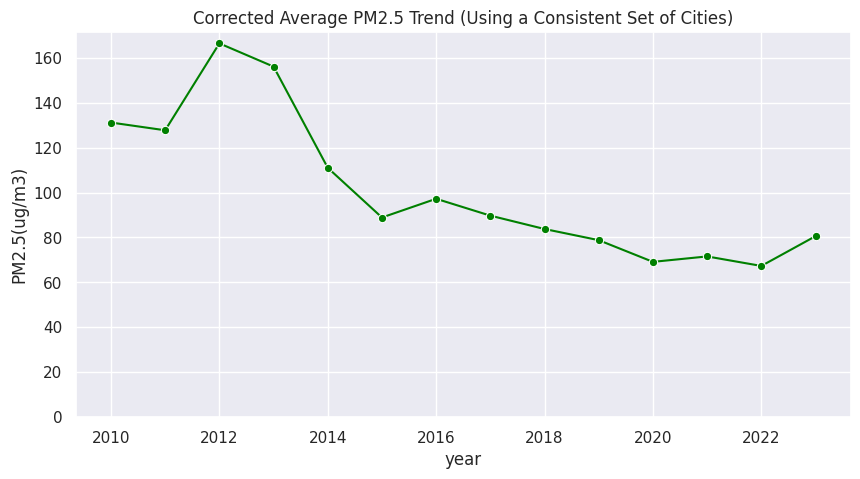

In [50]:
# CORRECTED TREND GRAPH--

# 1. find the cities that have been reproting for a long time .
# lets consider cities that were already reporting in 2017.

cities_in_2017  =master_df[master_df['year']==2017]['city'].unique()
print(f"Found {len(cities_in_2017)} cities that were reporting data back in 2017.")

# 2. create new dataframe contianing only the data for these consistent cities.

consistent_cities_df = master_df[master_df['city'].isin(cities_in_2017)]
print("Created a new dataframe with a consistent set of cities ")

# 3. recalculate the yearly trend of pm2.5 level

avg_pm25_year = consistent_cities_df.groupby('year')["PM2.5 (ug/m3)"].mean().reset_index()

# 4 plot new corrected trend

plt.figure(figsize = (10,5))
sns.lineplot(data = avg_pm25_year, x = 'year', y = 'PM2.5 (ug/m3)',marker = 'o',color = 'green')
plt.title('Corrected Average PM2.5 Trend (Using a Consistent Set of Cities)')
plt.ylabel('PM2.5(ug/m3)')
plt.xlabel('year')
plt.ylim(bottom = 0) # set the y axis to 0 
plt.show()


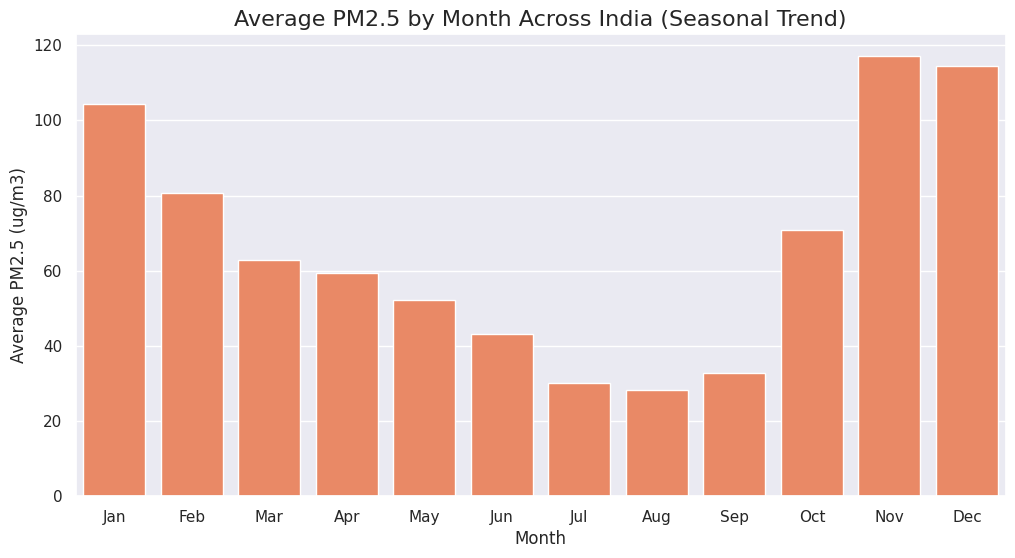

In [51]:
# MONTHLY SEASONAL TREND

# group the data by month and calculate the avg pm2.5 for each month
avg_pm25_month = master_df.groupby('month')['PM2.5 (ug/m3)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_pm25_month, x='month', y='PM2.5 (ug/m3)', color='coral')

plt.title('Average PM2.5 by Month Across India (Seasonal Trend)', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average PM2.5 (ug/m3)')

# Set month names for better readability
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


Top 10 Most Polluted Cities (based on average PM2.5):
         city  PM2.5 (ug/m3)
0    Byrnihat     235.016012
1   Begusarai     163.757926
2       Siwan     142.443542
3     Katihar     120.663256
4     Saharsa     117.543719
5      Purnia     116.002842
6     Chhapra     114.091822
7  Samastipur     113.722009
8     Bettiah     113.686279
9   Ghaziabad     111.332062


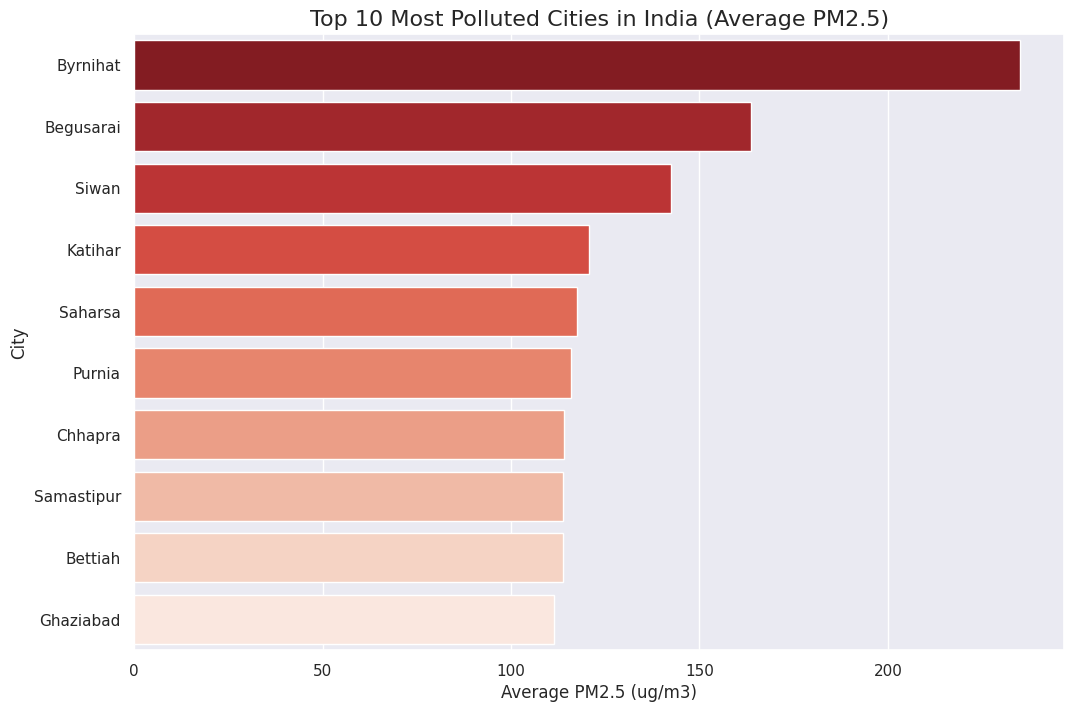

In [54]:
# TOP 10 MOST POLLUTED CITIES 

# Group by city and calculate the mean PM2.5
avg_pm25_city = master_df.groupby('city')['PM2.5 (ug/m3)'].mean()

# Get the top 10 cities with the highest average PM2.5
top_10_cities = avg_pm25_city.nlargest(10).reset_index()

print("Top 10 Most Polluted Cities (based on average PM2.5):")
print(top_10_cities)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_cities, x='PM2.5 (ug/m3)', y='city', palette='Reds_r')

plt.title('Top 10 Most Polluted Cities in India (Average PM2.5)', fontsize=16)
plt.xlabel('Average PM2.5 (ug/m3)')
plt.ylabel('City')
plt.show()

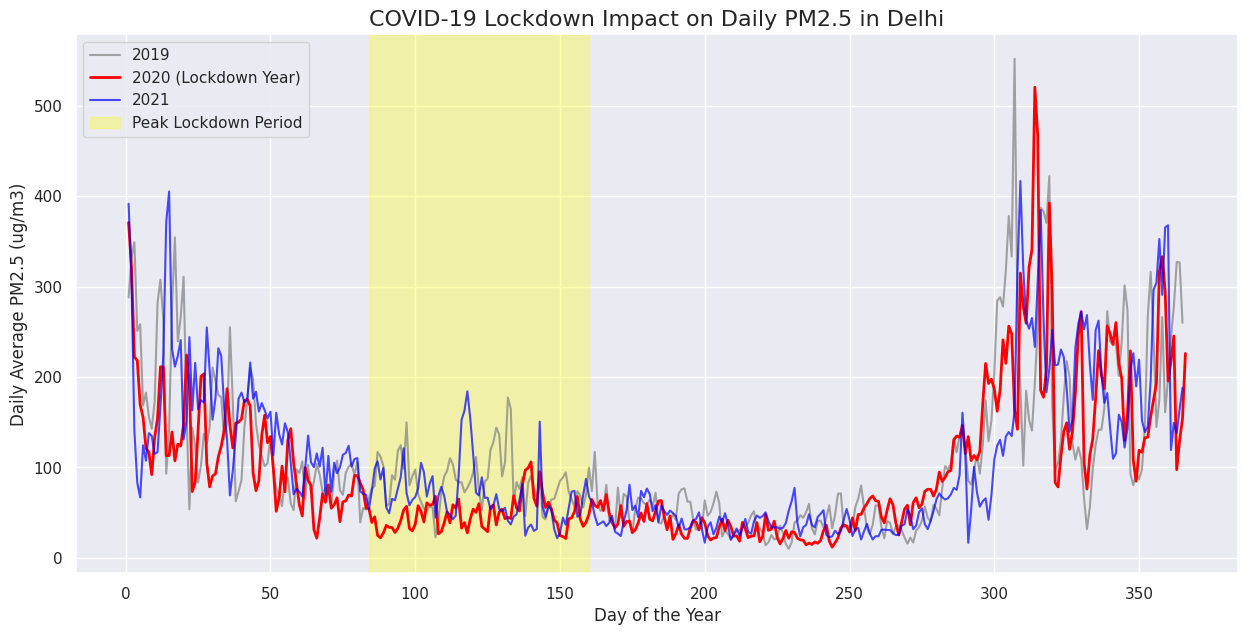

In [56]:
# COVID-19 LOCKDOWN IMPACT IN DELHI 

# Filter the dataset for a single city to get a clear view
delhi_df = master_df[master_df['city'] == 'Delhi'].copy()
delhi_df = delhi_df.set_index('date')


# Resample the hourly data to daily averages to make the plot cleaner
delhi_daily_2019 = delhi_df.loc['2019']['PM2.5 (ug/m3)'].resample('D').mean()
delhi_daily_2020 = delhi_df.loc['2020']['PM2.5 (ug/m3)'].resample('D').mean()
delhi_daily_2021 = delhi_df.loc['2021']['PM2.5 (ug/m3)'].resample('D').mean()

# Plot the comparison
plt.figure(figsize=(15, 7))
plt.plot(delhi_daily_2019.index.dayofyear, delhi_daily_2019.values, label='2019', color='gray', alpha=0.7)
plt.plot(delhi_daily_2020.index.dayofyear, delhi_daily_2020.values, label='2020 (Lockdown Year)', color='red', linewidth=2)
plt.plot(delhi_daily_2021.index.dayofyear, delhi_daily_2021.values, label='2021', color='blue', alpha=0.7)

# Highlight the main lockdown period (approx. late March to June)
lockdown_start_day = 84 # March 25th
lockdown_end_day = 160 # Approx. June 8th
plt.axvspan(lockdown_start_day, lockdown_end_day, color='yellow', alpha=0.3, label='Peak Lockdown Period')

plt.title('COVID-19 Lockdown Impact on Daily PM2.5 in Delhi', fontsize=16)
plt.xlabel('Day of the Year')
plt.ylabel('Daily Average PM2.5 (ug/m3)')
plt.legend()
plt.show()

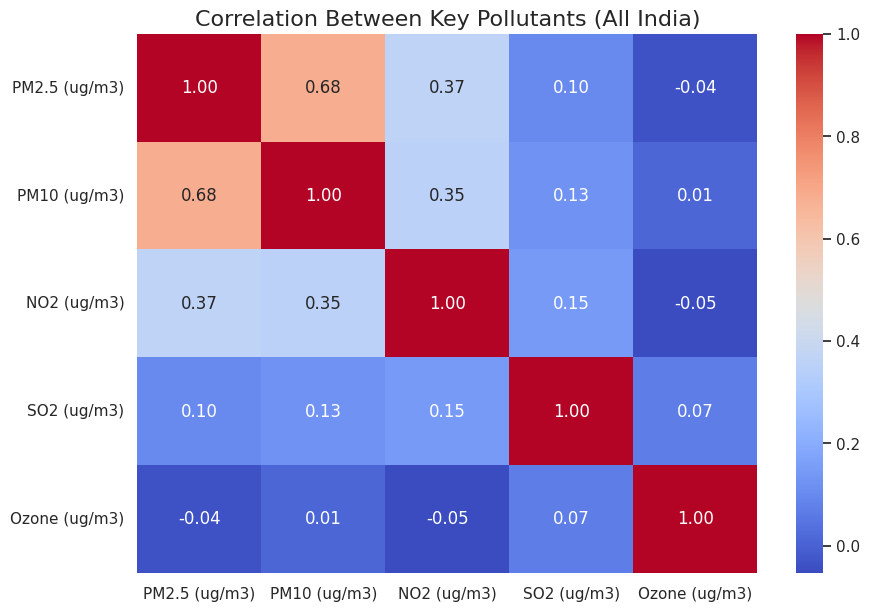

In [57]:
# Correlation analysis

# select the features
features = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)']

# Calculate the correlation matrix

corr = master_df[features].corr()

#plot the heatmap

plt.figure(figsize = (10,7))
sns.heatmap(corr,annot = True, cmap= "coolwarm",fmt = ".2f")
plt.title('Correlation Between Key Pollutants (All India)', fontsize=16)
plt.show()

STEP 3: PREDICTIVE MODELING


In [63]:

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

print(" Preparing Data for Modeling")

# Filter for Delhi and set the date as the index
delhi_df = master_df[master_df['city'] == 'Delhi'].copy().set_index('date')

numeric_cols = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)']
delhi_numeric_df = delhi_df[numeric_cols]

# resample the numeric-only DataFrame to a daily average.
delhi_daily_df = delhi_numeric_df.resample('D').mean()

# The resample might create new missing days. Let's fill them.
delhi_daily_df = delhi_daily_df.ffill()

# Create time-based and lagged features for the daily data
delhi_daily_df['month'] = delhi_daily_df.index.month
delhi_daily_df['day_of_week'] = delhi_daily_df.index.dayofweek

features_to_lag = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'SO2 (ug/m3)', 'Ozone (ug/m3)']
for feature in features_to_lag:
    delhi_daily_df[f'{feature}_prev_day'] = delhi_daily_df[feature].shift(1)

# Drop rows with any NaN values (this will remove the first row)
delhi_daily_df = delhi_daily_df.dropna()

print("Daily data prepared for Delhi:")
print(delhi_daily_df.head())

# 2. Define Features (X) and Target (y) 
X = delhi_daily_df[['month', 'day_of_week', 
                    'PM2.5 (ug/m3)_prev_day', 'PM10 (ug/m3)_prev_day', 
                    'NO2 (ug/m3)_prev_day', 'SO2 (ug/m3)_prev_day', 
                    'Ozone (ug/m3)_prev_day']]
y = delhi_daily_df['PM2.5 (ug/m3)']

# 3. Create Time-Based Train-Test Split
split_date = '2022-01-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")



 Preparing Data for Modeling
Daily data prepared for Delhi:
            PM2.5 (ug/m3)  PM10 (ug/m3)  NO2 (ug/m3)  SO2 (ug/m3)  \
date                                                                
2010-02-18     135.687500          50.0    43.364583     1.255833   
2010-02-19     183.972222          50.0    46.694444     3.249444   
2010-02-20     183.972222          50.0    46.694444     3.249444   
2010-02-21     183.972222          50.0    46.694444     3.249444   
2010-02-22     183.972222          50.0    46.694444     3.249444   

            Ozone (ug/m3)  month  day_of_week  PM2.5 (ug/m3)_prev_day  \
date                                                                    
2010-02-18      34.989583      2            3              135.854167   
2010-02-19      39.263889      2            4              135.687500   
2010-02-20      39.263889      2            5              183.972222   
2010-02-21      39.263889      2            6              183.972222   
2010-02-22      39

In [66]:
# 4. Train and Evaluate Models 

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print(f"Linear Regression - MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}, R²: {r2_score(y_test, y_pred_lr):.2f}")



Linear Regression - MAE: 22.57, R²: 0.75


In [67]:
# Decision Tree Regressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f"Decision Tree - MAE: {mean_absolute_error(y_test, y_pred_dt):.2f}, R²: {r2_score(y_test, y_pred_dt):.2f}")



Decision Tree - MAE: 31.80, R²: 0.48


In [69]:
#Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest - MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}, R²: {r2_score(y_test, y_pred_rf):.2f}")



Random Forest - MAE: 20.88, R²: 0.77


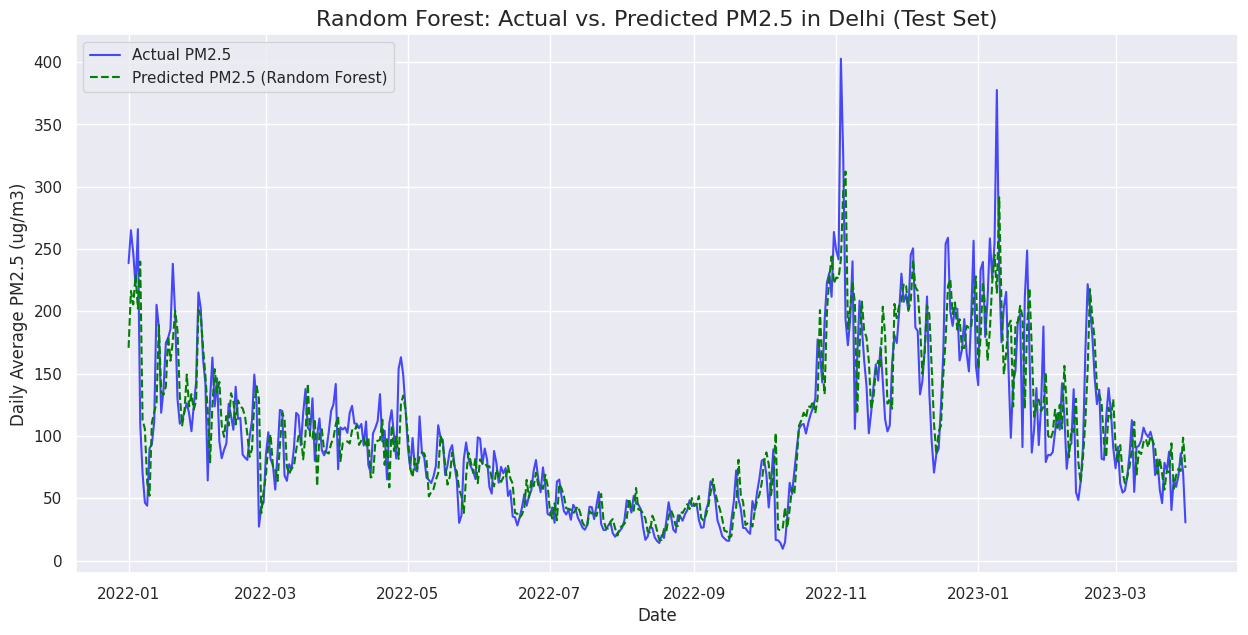

In [70]:
# Visualize Predictions of the Best Model (Random Forest) 

plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual PM2.5', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred_rf, label='Predicted PM2.5 (Random Forest)', color='green', linestyle='--')
plt.title('Random Forest: Actual vs. Predicted PM2.5 in Delhi (Test Set)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Daily Average PM2.5 (ug/m3)')
plt.legend()
plt.show()

STEP 4: FEATURE IMPORTANCE

Feature Importances from Random Forest Model:
                  Feature  Importance
2  PM2.5 (ug/m3)_prev_day    0.772526
4    NO2 (ug/m3)_prev_day    0.060190
6  Ozone (ug/m3)_prev_day    0.050609
5    SO2 (ug/m3)_prev_day    0.041281
3   PM10 (ug/m3)_prev_day    0.033394
0                   month    0.021483
1             day_of_week    0.020517


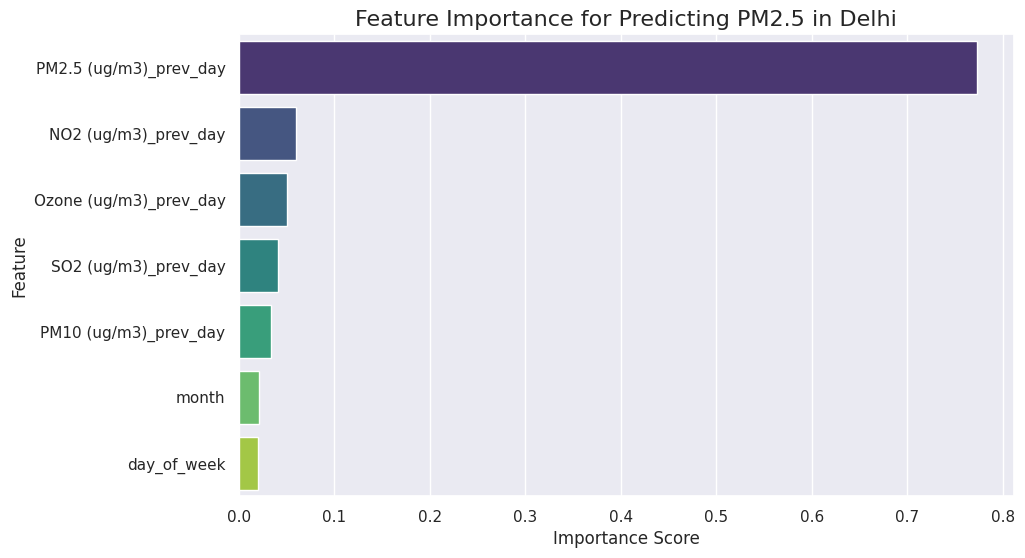

In [71]:

# 1. Get feature importances from our best model (Random Forest)
importances = rf_model.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame 
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Random Forest Model:")
print(importance_df)

# 3. Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance for Predicting PM2.5 in Delhi', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [73]:
import joblib
import os

# Final Step: Save the Trained Model ---

# Ensure the '/kaggle/working/' directory exists 
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Define the full path for the model file
model_filename = os.path.join(output_dir, 'random_forest_model.joblib')

# Save the trained Random Forest model
joblib.dump(rf_model, model_filename)

print(f"Model saved successfully to: {model_filename}")

Model saved successfully to: /kaggle/working/random_forest_model.joblib
